In [21]:
# What we have:
# - simple and cyclical encoding preprocessing on dates
# - WindAsCyclicalFeature transformer
# - OutliersCleaner; 2 strategies, 2 methods
# - simple preprocessor:
#   * categorical feat.: impute mode, ohe
#   * numerical feat.: impute mean, min max scaling
# - SMOTE technique for handling imbalanced targets
# - default log. reg. and gridsearchcv with log. reg.
# - default decision tree and gridsearchcv with decision tree
# - default xgboost and gridsearchcv with xgboost
# - SequentialFeatureSelector('forward') with differenct 'tol' param. values
# - RFECV with different scoring metrics
# - MICE imputation

In [1]:
from IPython.core.interactiveshell import InteractiveShell; InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML;  display(HTML('<style>.container { width:95% !important; }</style>'))

In [2]:
!pip install scikit-learn-intelex  # google colab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.7/128.7 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 108.7 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb # google colab

from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, FunctionTransformer, binarize
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report
from sklearn.base import TransformerMixin, BaseEstimator, clone
from sklearn.feature_selection import SequentialFeatureSelector, RFECV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from imblearn.over_sampling import SMOTE

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_rows', 50)

# Data exploration

In [5]:
# google colab
from google.colab import drive
drive.mount('/content/drive')
df_weather_aus = pd.read_csv('/content/drive/MyDrive/kurs_Data_Science_2022/rain_in_australia/weatherAUS.csv')

Mounted at /content/drive


In [ ]:
# jupyter-lab
df_weather_aus = pd.read_csv('weatherAUS.csv')

In [15]:
df_weather_aus.shape

(145460, 23)

In [16]:
df_weather_aus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [17]:
df_weather_aus.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


In [18]:
for col in df_weather_aus.columns:
    print(f'{col}: {df_weather_aus[col].nunique()} unique values')

Date: 3436 unique values
Location: 49 unique values
MinTemp: 389 unique values
MaxTemp: 505 unique values
Rainfall: 681 unique values
Evaporation: 358 unique values
Sunshine: 145 unique values
WindGustDir: 16 unique values
WindGustSpeed: 67 unique values
WindDir9am: 16 unique values
WindDir3pm: 16 unique values
WindSpeed9am: 43 unique values
WindSpeed3pm: 44 unique values
Humidity9am: 101 unique values
Humidity3pm: 101 unique values
Pressure9am: 546 unique values
Pressure3pm: 549 unique values
Cloud9am: 10 unique values
Cloud3pm: 10 unique values
Temp9am: 441 unique values
Temp3pm: 502 unique values
RainToday: 2 unique values
RainTomorrow: 2 unique values


In [19]:
# Quantity of missing values in 'RainTomorrow' (target) and 'RainToday' feature
# ('RainToday' feature is connected with 'RainTomorrow')
print(f'RainTomorrow has: {(df_weather_aus["RainTomorrow"].isna().sum() / df_weather_aus.shape[0]).round(2)} missing values.')
print(f'RainToday has: {(df_weather_aus["RainToday"].isna().sum() / df_weather_aus.shape[0]).round(2)} missing values.')

RainTomorrow has: 0.02 missing values.
RainToday has: 0.02 missing values.


In [6]:
# Let's drop observations with missing values in 'RainToday' and 'RainTomorrow'
df_weather_aus.dropna(how='any', subset='RainTomorrow', inplace=True)
df_weather_aus.dropna(how='any', subset='RainToday', inplace=True)

In [21]:
# Shape of dataframe after droping some observations
df_weather_aus.shape

(140787, 23)

In [24]:
df_weather_aus.isna().mean()

Date             0.000000
Location         0.000000
MinTemp          0.003324
MaxTemp          0.002181
Rainfall         0.000000
Evaporation      0.424002
Sunshine         0.474511
WindGustDir      0.065084
WindGustSpeed    0.064672
WindDir9am       0.068614
WindDir3pm       0.026068
WindSpeed9am     0.007494
WindSpeed3pm     0.017978
Humidity9am      0.010775
Humidity3pm      0.024867
Pressure9am      0.097616
Pressure3pm      0.097800
Cloud9am         0.373792
Cloud3pm         0.398432
Temp9am          0.004660
Temp3pm          0.018638
RainToday        0.000000
RainTomorrow     0.000000
dtype: float64

In [7]:
# binary encoding of 'RainTomorrow' target
df_weather_aus['RainTomorrow'] = df_weather_aus['RainTomorrow'].map({'Yes': 1, 'No': 0})

In [26]:
# As we can see, 'RainTomorrow' target is imbalanced
df_weather_aus['RainTomorrow'].value_counts(normalize=True)

0    0.778382
1    0.221618
Name: RainTomorrow, dtype: float64

In [27]:
df_weather_aus['Date'].min()      # earliest observation date
df_weather_aus['Date'].max()      # latest observation date

'2007-11-01'

'2017-06-25'

In [8]:
categorical_features = df_weather_aus.select_dtypes(include='object').columns.to_list()
# for now let's exclude 'Date', from list - we will handle it later
categorical_features = [cat for cat in categorical_features if cat != 'Date']

numerical_features = df_weather_aus.select_dtypes(include=['int', 'float']).columns.to_list()
# let's exclude 'RainTomorrow' target from list
numerical_features = [feature for feature in numerical_features if feature != 'RainTomorrow']

In [29]:
categorical_features
numerical_features

['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm']

In [30]:
# there is no major imbalance in categorical features
for feature in categorical_features:
    print(f'{feature} - least frequent: {df_weather_aus[feature].value_counts().min()}, most frequent: {df_weather_aus[feature].value_counts().max()}')

Location - least frequent: 1502, most frequent: 3402
WindGustDir - least frequent: 6372, most frequent: 9696
WindDir9am - least frequent: 6786, most frequent: 11266
WindDir3pm - least frequent: 6373, most frequent: 10578
RainToday - least frequent: 31455, most frequent: 109332


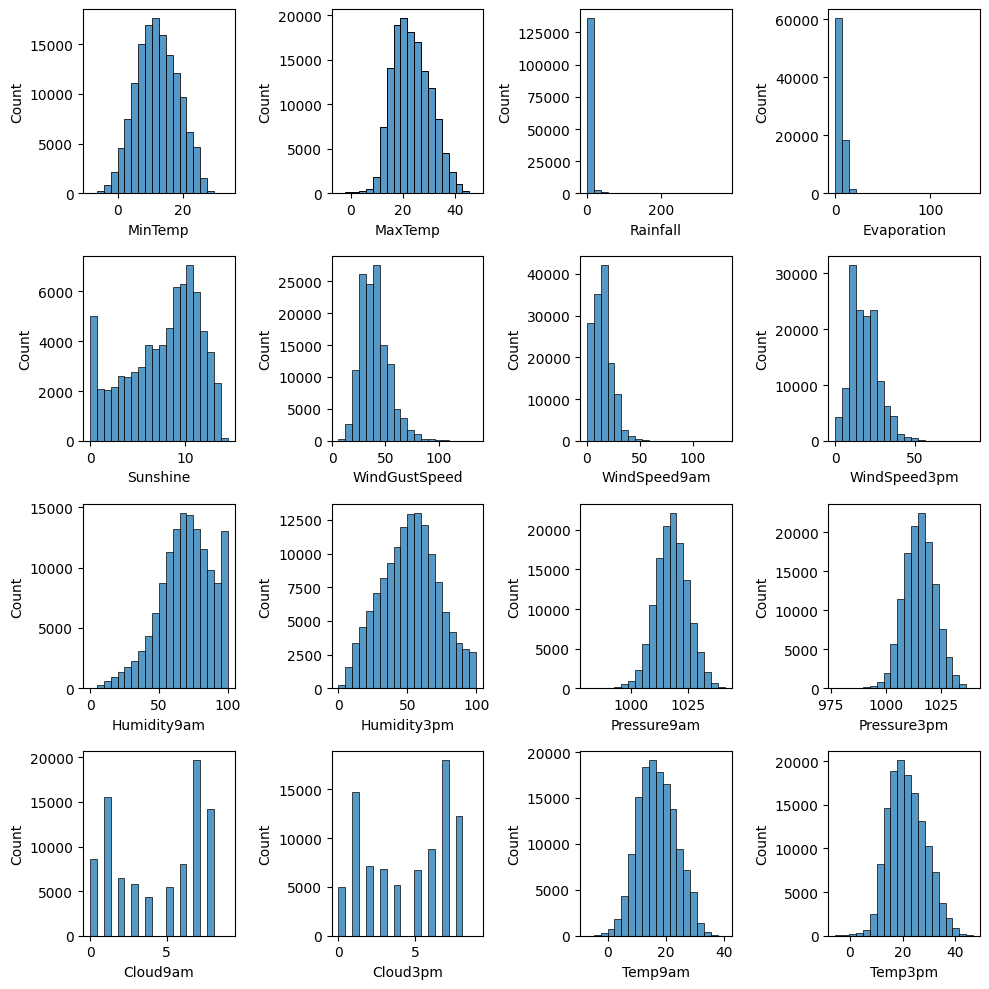

In [39]:
plt.figure(figsize=(10,10))
for idx, feature in enumerate(numerical_features):
    plt.subplot(4, 4, idx+1)
    sns.histplot(X[feature], bins=20)
    plt.tight_layout()

plt.show();

,lower_boundaries,upper_boundaries,outliers_observations_ratio,num_of_outliers
Rainfall,0.0,2.0,0.179193,25228.0
Evaporation,0.0,14.6,0.013829,1947.0
WindGustSpeed,5.5,73.5,0.021039,2962.0
WindSpeed9am,0.0,37.0,0.012182,1715.0
WindSpeed3pm,0.0,40.5,0.017189,2420.0
Humidity9am,18.0,122.0,0.010044,1414.0


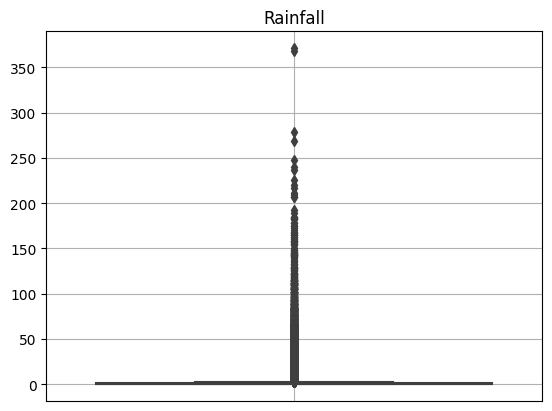

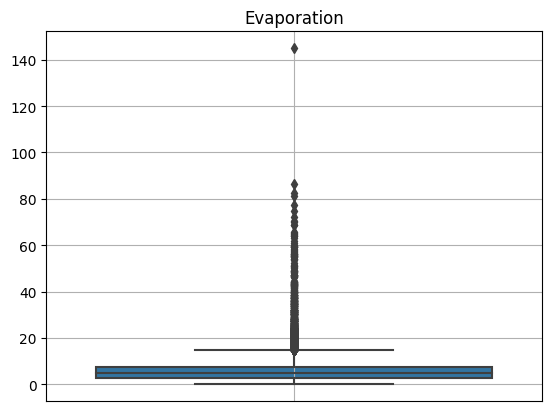

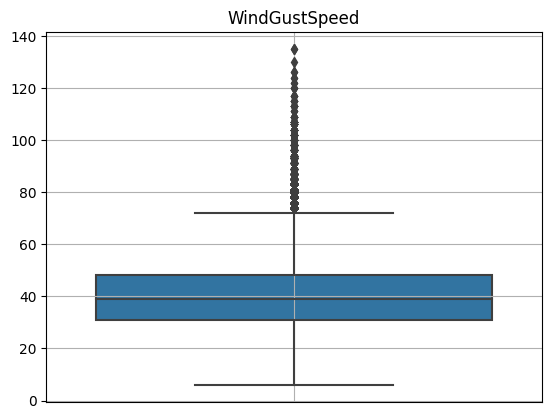

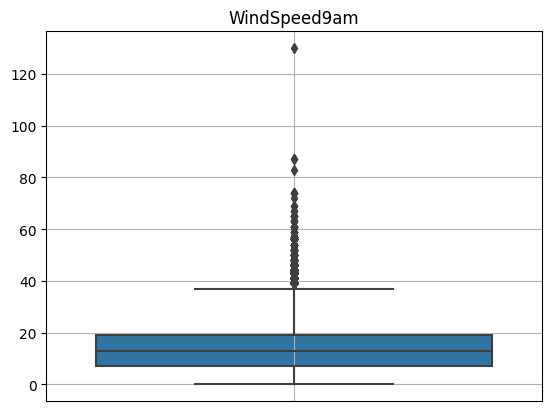

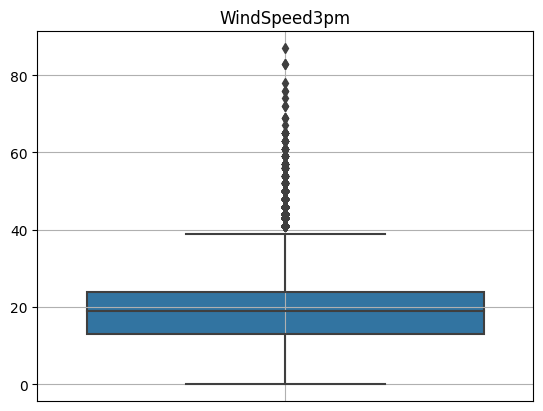

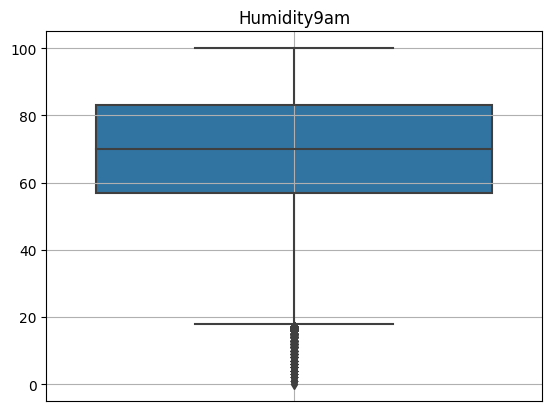

In [40]:
handle_outliers(df_weather_aus, numerical_features, method='iqr', use_for_analysis=True, out_obs_threshold=0.01)

In [41]:
handle_outliers(df_weather_aus, numerical_features, method='percentile_5_95', use_for_analysis=True, out_obs_threshold=0.09)

,lower_boundaries,upper_boundaries,outliers_observations_ratio,num_of_outliers
MinTemp,1.800,23.0,0.098766,13905.0
MaxTemp,12.895,35.5,0.098397,13853.0
Humidity9am,34.000,98.0,0.091123,12829.0
Temp9am,6.900,28.2,0.097253,13692.0
Temp3pm,11.500,33.7,0.095243,13409.0


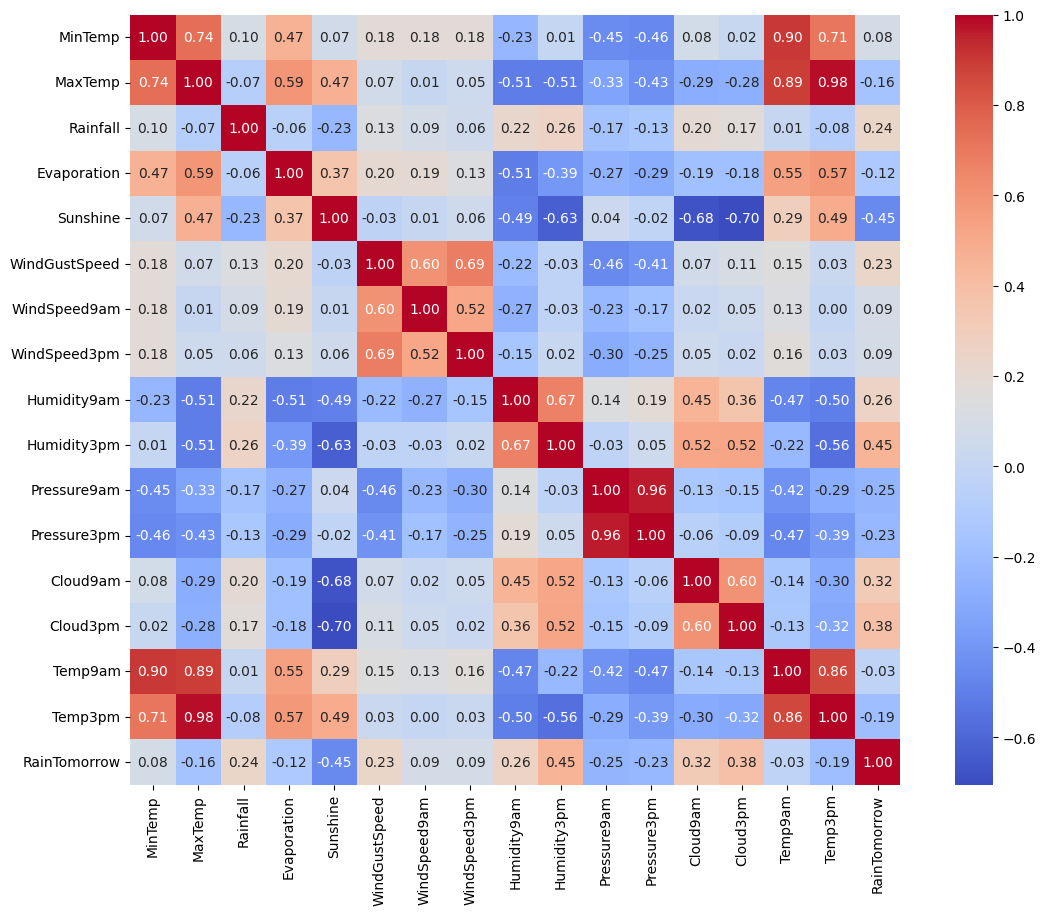

In [42]:
plt.figure(figsize=(14,10))
heatmap = sns.heatmap(df_weather_aus.corr(numeric_only=True), square=True, annot=True, fmt='.2f', cmap='coolwarm')
plt.show();

In [9]:
X = df_weather_aus.drop(columns='RainTomorrow')
y = df_weather_aus['RainTomorrow']

# Functions, Transformers

### handle_outliers func

In [10]:
def handle_outliers(df, features, method='iqr', use_for_analysis=False, out_obs_threshold=0.05):
    outliers_stats = {}

    for feature in features:
        values = df[feature]
        outliers_stats[feature] = []

        if method == 'iqr':
            q1 = values.quantile(0.25)
            q3 = values.quantile(0.75)
            iqr = q3 - q1
            lower_boundary = q1 - 1.5 * iqr
            upper_boundary = q3 + 1.5 * iqr

        elif method == 'percentile_5_95':
            lower_boundary = values.quantile(0.05)
            upper_boundary = values.quantile(0.95)

        if feature not in ['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm'] and lower_boundary < 0:
            lower_boundary = 0

        outliers_stats[feature].extend([lower_boundary, upper_boundary])
        if use_for_analysis:
            outliers = values[(values < lower_boundary) | (values > upper_boundary)]
            outliers_observations_ratio = len(outliers) / len(values)
            if outliers_observations_ratio >= out_obs_threshold:
                outliers_stats[feature].extend([outliers_observations_ratio, len(outliers)])
                if method == 'iqr':
                    plt.figure()
                    boxplot = sns.boxplot(values)
                    boxplot.set(title=feature, xticklabels=[])  # don't show '0' on xticks
                    boxplot.tick_params(bottom=False)   # don't show bottom ticks
                    plt.grid()
            else:
                # remove feature from further analysis if it doesn't exceed threshold
                outliers_stats.pop(feature)

    if use_for_analysis:
        outliers_stats_values = list(outliers_stats.values())
        lower_boundaries = np.array([val[0] for val in outliers_stats_values])[:, np.newaxis]
        upper_boundaries = np.array([val[1] for val in outliers_stats_values])[:, np.newaxis]
        outliers_observations_ratios = np.array([val[2] for val in outliers_stats_values])[:, np.newaxis]
        nums_of_outliers = np.array([val[3] for val in outliers_stats_values])[:, np.newaxis]
        outliers_stats_array = np.hstack((lower_boundaries, upper_boundaries, outliers_observations_ratios, nums_of_outliers))
        outliers_stats_df = pd.DataFrame(
            data=outliers_stats_array,
            columns=['lower_boundaries', 'upper_boundaries', 'outliers_observations_ratio', 'num_of_outliers'],
            index=list(outliers_stats.keys())
        )
        return outliers_stats_df
    else:
        return outliers_stats

### preprocess func

In [11]:
def preprocess(X, dates_cyclical_encoding=False):
    date_series = pd.to_datetime(X['Date'])

    if dates_cyclical_encoding:
        X['month_sin'] = np.sin(date_series.dt.month * 2 * np.pi / 12)
        X['month_cos'] = np.cos(date_series.dt.month * 2 * np.pi / 12)
        X['day_sin'] = np.sin(date_series.dt.dayofyear * 2 * np.pi / 365)
        X['day_cos'] = np.cos(date_series.dt.dayofyear * 2 * np.pi / 365)
    else:
        X['Month'] = date_series.dt.month

    X.drop(columns='Date', inplace=True)

### predict_and_calculate_metrics func

In [12]:
def predict_and_calculate_metrics(X, y, model, threshold_lowered_to=None):
    y_probs = model.predict_proba(X)[:,1]
    if threshold_lowered_to:
        y_probs = y_probs.reshape(-1, 1)
        y_pred = binarize(y_probs, threshold=threshold_lowered_to)
    else:
        y_pred = model.predict(X)

    accuracy = accuracy_score(y, y_pred)
    auc = roc_auc_score(y, y_probs)
    report = classification_report(y, y_pred)
    conf_matrix = confusion_matrix(y, y_pred)

    return accuracy, auc, report, conf_matrix

### handle_with_smote func

In [13]:
def handle_with_smote(X_train, X_test, y_train, preprocessor):
    X_train = pd.DataFrame(
        # convert sparse matrix to DataFrame to accelerate SMOTE() performance
        data=preprocessor.fit_transform(X_train, y_train).toarray(),
        columns=preprocessor.get_feature_names_out())
    X_train, y_train = SMOTE().fit_resample(X_train, y_train)
    X_test = pd.DataFrame(
        data=preprocessor.transform(X_test).toarray(),
        columns=preprocessor.get_feature_names_out())

    return X_train, X_test, y_train

### split_and_train_model func

In [14]:
def split_and_train_model(preprocessor, model, param_grid=None, smote=False):
    '''
    param_grid:
    use syntax 'step__param' e.g. 'model__penalty' when you preprocess data
    without SMOTE, otherwise use syntax 'param' e.g. 'penalty'
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    preprocess(X_train)
    preprocess(X_test)

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    if smote:
        # use step 'preprocessor' of pipeline -> smote -> use step 'model'
        preprocessor=pipeline.named_steps['preprocessor']
        X_train, X_test, y_train = handle_with_smote(
            X_train, X_test, y_train, preprocessor)


    # use step 'model' of pipeline if you use smote technique,
    # otherwise use whole pipeline to transform data and fit model
    model_or_pipeline = pipeline.named_steps['model'] if smote else pipeline
    if param_grid:
        optimizer = GridSearchCV(
            model_or_pipeline, param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
        optimizer.fit(X_train, y_train)
    else:
        model_or_pipeline.fit(X_train, y_train)

    opt_model_or_pipe = optimizer.best_estimator_ if param_grid \
        else model_or_pipeline
    test_metrics = predict_and_calculate_metrics(
        X_test, y_test, opt_model_or_pipe)
    train_metrics = predict_and_calculate_metrics(
        X_train, y_train, opt_model_or_pipe)

    return test_metrics, train_metrics, opt_model_or_pipe

In [63]:
def handle_with_smote__2(X_train, X_test, y_train, preprocessor):
    X_train = pd.DataFrame(
        # convert sparse matrix to DataFrame to accelerate SMOTE() performance
        data=preprocessor.fit_transform(X_train, y_train).toarray(),
        columns=preprocessor.named_steps['preprocessor'].get_feature_names_out())
    X_train, y_train = SMOTE().fit_resample(X_train, y_train)
    X_test = pd.DataFrame(
        data=preprocessor.transform(X_test).toarray(),
        columns=preprocessor.named_steps['preprocessor'].get_feature_names_out())

    return X_train, X_test, y_train

In [64]:
def split_and_train_model__2(preprocessor, model, param_grid=None, smote=False):
    '''
    param_grid:
    use syntax 'step__param' e.g. 'model__penalty' when you preprocess data
    without SMOTE, otherwise use syntax 'param' e.g. 'penalty'
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    preprocess(X_train)
    preprocess(X_test)

    if smote:
        X_train, X_test, y_train = handle_with_smote__2(
            X_train, X_test, y_train, preprocessor)
        model.fit(X_train, y_train)

    test_metrics = predict_and_calculate_metrics(
        X_test, y_test, model)
    train_metrics = predict_and_calculate_metrics(
        X_train, y_train, model)

    return test_metrics, train_metrics, model

### create_metrics_dataframe func

In [15]:
def create_metrics_dataframe(accuracy, auc, report, conf_matrix, split_of_data=['Test', 'Train']):
    print(f'{split_of_data} Data:')
    print('----------------------')
    print(f'Accuracy score: {accuracy}')
    print(f'ROC AUC score: {auc}')
    print('\n')
    print(report)
    conf_matrix = pd.DataFrame(
        data=conf_matrix,
        index=['Actual Negative (no rain)', 'Actual Positive (rain)'],
        columns=['Predicted Negative (no rain)', 'Predicted Positive (rain)']
    )
    return conf_matrix

### WindAsCyclicalFeature class

In [16]:
class WindAsCyclicalFeature(TransformerMixin, BaseEstimator):

    # 'X_array' as parameter's name because there is always numpy array as input for this class
    def fit(self, X_array, y=None):
        return self

    def transform(self, X_array):
        wind_direction_dict = {
        'N': 1, 'NNE': 2, 'NE': 3, 'ENE': 4,
        'E': 5, 'ESE': 6, 'SE': 7, 'SSE': 8,
        'S': 9, 'SSW': 10, 'SW': 11, 'WSW': 12,
        'W': 13, 'WNW': 14, 'NW': 15, 'NNW': 16
        }
        wind_mapped = np.vectorize(wind_direction_dict.get)(X_array)

        wind_gust_dir_sin = np.sin(wind_mapped[:,0] * 2 * np.pi / 16)
        wind_gust_dir_cos = np.cos(wind_mapped[:,0] * 2 * np.pi / 16)

        wind_dir_9am_sin = np.sin(wind_mapped[:,1] * 2 * np.pi / 16)
        wind_dir_9am_cos = np.cos(wind_mapped[:,1] * 2 * np.pi / 16)

        wind_dir_3pm_sin = np.sin(wind_mapped[:,2] * 2 * np.pi / 16)
        wind_dir_3pm_cos = np.cos(wind_mapped[:,2] * 2 * np.pi / 16)

        winds_sin_cos_array = np.hstack((
            wind_gust_dir_sin[:, np.newaxis],
            wind_gust_dir_cos[:, np.newaxis],
            wind_dir_9am_sin[:, np.newaxis],
            wind_dir_9am_cos[:, np.newaxis],
            wind_dir_3pm_sin[:, np.newaxis],
            wind_dir_3pm_cos[:, np.newaxis]
        ))

        return winds_sin_cos_array

    def get_feature_names_out(self, input_features=None):
        return ['sin_WindGustDir', 'cos_WindGustDir', 'sin_WindDir9am', 'cos_WindDir9am', 'sin_WindDir3pm', 'cos_WindDir3pm']

### OutliersCleaner class

In [17]:
class OutliersCleaner(TransformerMixin, BaseEstimator):
    def __init__(self, columns, strategy='drop_outliers', method='iqr'):
        self.columns = columns
        self.strategy = strategy
        self.method = method

    def fit(self, X, y=None):  # pandas.DataFrame on input
        self.outliers_stats = handle_outliers(df=X, features=self.columns, method=self.method)
        return self

    def transform(self, X):   # pandas.DataFrame on input
        # TODO - improve drop_outliers strategy; right now outliers boundaries are found for every feature simultaneously,
        #        create strategy of finding outlier boundaries (and droping outliers) for one feature and then finding outlier boundaries for next feature etc.,
        #        every next iteration will have different set of values because of dropped observations
        for feature in self.columns:
            if self.strategy == 'drop_outliers':
                first_condition = (X[feature] >= self.outliers_stats[feature][0]) & (X[feature] <= self.outliers_stats[feature][1]) & (~X[feature].isna())
                second_condition = X[feature].isna()
                X = X[first_condition | second_condition]   # drop only outliers, remain missing values
            elif self.strategy == 'flooring_and_capping':
                X[feature] = np.where(X[feature] < self.outliers_stats[feature][0], self.outliers_stats[feature][0], X[feature])
                X[feature] = np.where(X[feature] > self.outliers_stats[feature][1], self.outliers_stats[feature][1], X[feature])
        self.df_before_strategy = X
        self.original_indexes = list(X.index)   # indexes needed to reindex transformed DataFrame and to drop corresponding targets
        return X  # pandas.DataFrame on output

### simple_preprocessor transformer

In [18]:
simple_preprocessor = ColumnTransformer([
    ('categorical_branch', Pipeline([
        ('missing_imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(drop='if_binary'))
    ]), categorical_features),
    ('numerical_branch', Pipeline([
        ('missing_imputer', SimpleImputer(strategy='median')),
        ('min_max_scaler', MinMaxScaler())
    ]), numerical_features)
], remainder='passthrough')

### wind_handler_preprocessor transformer

In [19]:
wind_handler_preprocessor = ColumnTransformer([
    ('wind_categorical_branch', Pipeline([
        ('missing_imputer', SimpleImputer(strategy='most_frequent')),
        ('wind_transformer', WindAsCyclicalFeature())
    ]), ['WindGustDir', 'WindDir9am', 'WindDir3pm']),
    ('other_categorical_branch', Pipeline([
        ('missing_imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(drop='if_binary'))
    ]), ['Location', 'RainToday']),
    ('numerical_branch', Pipeline([
        ('missing_imputer', SimpleImputer(strategy='median')),
        ('min_max_scaler', MinMaxScaler())
    ]), numerical_features)
], remainder='passthrough')

# Comparison of models with default parametrs

## Logisitc Regression

In [29]:
# Increased number of iterations (max_iter); otherwise solver would fail to converge
test_metrics, train_metrics, _ = split_and_train_model(simple_preprocessor, LogisticRegression(max_iter=1000))

In [30]:
create_metrics_dataframe(*test_metrics, 'Test')

Test Data:
----------------------
Accuracy score: 0.8504865402372328
ROC AUC score: 0.8752286426008935


              precision    recall  f1-score   support

           0       0.87      0.95      0.91     21821
           1       0.74      0.52      0.61      6337

    accuracy                           0.85     28158
   macro avg       0.81      0.73      0.76     28158
weighted avg       0.84      0.85      0.84     28158



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),20684,1137
Actual Positive (rain),3073,3264


In [31]:
create_metrics_dataframe(*train_metrics, 'Train')

Train Data:
----------------------
Accuracy score: 0.8504559216542809
ROC AUC score: 0.8729921670028062


              precision    recall  f1-score   support

           0       0.87      0.95      0.91     87765
           1       0.73      0.51      0.60     24864

    accuracy                           0.85    112629
   macro avg       0.80      0.73      0.75    112629
weighted avg       0.84      0.85      0.84    112629



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),83105,4660
Actual Positive (rain),12183,12681




* Poor recall for predicting rain (target is an imbalanced class) and no signs of overfitting.

## DecisionTree

In [78]:
test_metrics, train_metrics, pipeline = split_and_train_model(simple_preprocessor, DecisionTreeClassifier())

In [79]:
create_metrics_dataframe(*test_metrics, 'Test')

Test Data:
----------------------
Accuracy score: 0.7932026422331131
ROC AUC score: 0.705202631355234


              precision    recall  f1-score   support

           0       0.87      0.86      0.87     21878
           1       0.54      0.55      0.54      6280

    accuracy                           0.79     28158
   macro avg       0.70      0.71      0.70     28158
weighted avg       0.79      0.79      0.79     28158



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),18905,2973
Actual Positive (rain),2850,3430


In [80]:
create_metrics_dataframe(*train_metrics, 'Train')

Train Data:
----------------------
Accuracy score: 0.9999911212920296
ROC AUC score: 0.9999999995424955


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87708
           1       1.00      1.00      1.00     24921

    accuracy                           1.00    112629
   macro avg       1.00      1.00      1.00    112629
weighted avg       1.00      1.00      1.00    112629



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),87708,0
Actual Positive (rain),1,24920


* ROC AUC score for test data is 0.71, whereas for training data is 1.0. There is clearly an overfitting.

In [81]:
pipeline.steps[1][1].get_depth(), pipeline.steps[1][1].get_n_leaves()

(51, 12630)

* Depth of this tree and its number of leaves suggest that this decission tree is overgrown.

## RandomForest

In [82]:
test_metrics, train_metrics, _ = split_and_train_model(simple_preprocessor, RandomForestClassifier())

In [83]:
create_metrics_dataframe(*test_metrics, 'Test')

Test Data:
----------------------
Accuracy score: 0.8563463314155835
ROC AUC score: 0.8840437690271463


              precision    recall  f1-score   support

           0       0.87      0.96      0.91     21912
           1       0.78      0.49      0.60      6246

    accuracy                           0.86     28158
   macro avg       0.83      0.72      0.76     28158
weighted avg       0.85      0.86      0.84     28158



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),21062,850
Actual Positive (rain),3195,3051


In [84]:
create_metrics_dataframe(*train_metrics, 'Train')

Train Data:
----------------------
Accuracy score: 0.9999733638760887
ROC AUC score: 1.0


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87674
           1       1.00      1.00      1.00     24955

    accuracy                           1.00    112629
   macro avg       1.00      1.00      1.00    112629
weighted avg       1.00      1.00      1.00    112629



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),87674,0
Actual Positive (rain),3,24952


* This model highly overfits.

## XGBoost

In [19]:
test_metrics, train_metrics, _ = split_and_train_model(simple_preprocessor, xgb.XGBClassifier(tree_method='gpu_hist'))

In [20]:
create_metrics_dataframe(*test_metrics, 'Test')

Test Data:
----------------------
Accuracy score: 0.8614248171034875
ROC AUC score: 0.8947209122721974


              precision    recall  f1-score   support

           0       0.88      0.94      0.91     21923
           1       0.75      0.57      0.64      6235

    accuracy                           0.86     28158
   macro avg       0.82      0.76      0.78     28158
weighted avg       0.85      0.86      0.85     28158



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),20715,1208
Actual Positive (rain),2694,3541


In [21]:
create_metrics_dataframe(*train_metrics, 'Train')

Train Data:
----------------------
Accuracy score: 0.8904545010610057
ROC AUC score: 0.9366448240361943


              precision    recall  f1-score   support

           0       0.90      0.96      0.93     87663
           1       0.83      0.63      0.72     24966

    accuracy                           0.89    112629
   macro avg       0.87      0.80      0.83    112629
weighted avg       0.89      0.89      0.88    112629



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),84536,3127
Actual Positive (rain),9211,15755


* This model calculates most accurate predictions so far but it's slightly overfitted (train ROC-AUC score: 0.94 vs test ROC-AUC score: 0.89)

# Next steps

**Next I will look for best parameters for LogisticRegression, DecisionTree and XGBoost using GridSearchCV. Target variable will be preprocessed with SMOTE technique for handling imbalances. I will also use different techniques for preprocessing features overall.**

# GridSearchCV(Logistic Regression)

In [47]:
# 1h 10 min., google colab, CPU
log_reg_param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10, 100, 1000],
    'solver':['lbfgs', 'saga'],
    'fit_intercept': [True, False]
}

test_metrics, train_metrics, log_reg_optimizer = split_and_train_model(
    simple_preprocessor,
    LogisticRegression(max_iter=1000),
    log_reg_param_grid,
    smote=True)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
50 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/daal4py/sklearn/_device_offload.py", line 88, in wrapper_with_self
    return wrapper_impl(self, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/daal4py/sklearn/_device_offload.py", line 74, in wrapper_impl
    result = _run_on_device(func, q, obj, *

In [53]:
log_reg_optimizer.get_params()

{'C': 1000,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': None,
 'solver': 'saga',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [54]:
create_metrics_dataframe(*test_metrics, 'Test')

Test Data:
----------------------
Accuracy score: 0.7963278641949002
ROC AUC score: 0.8721486053085576


              precision    recall  f1-score   support

           0       0.92      0.80      0.86     21873
           1       0.53      0.77      0.63      6285

    accuracy                           0.80     28158
   macro avg       0.73      0.79      0.74     28158
weighted avg       0.84      0.80      0.81     28158



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),17564,4309
Actual Positive (rain),1426,4859


In [55]:
create_metrics_dataframe(*train_metrics, 'Train')

Train Data:
----------------------
Accuracy score: 0.8043676535975283
ROC AUC score: 0.88692252526793


              precision    recall  f1-score   support

           0       0.80      0.81      0.81     87713
           1       0.81      0.80      0.80     87713

    accuracy                           0.80    175426
   macro avg       0.80      0.80      0.80    175426
weighted avg       0.80      0.80      0.80    175426



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),70984,16729
Actual Positive (rain),17590,70123


# GridSearchCV(DecisionTree)

In [ ]:
dt_param_grid = {
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3]
}

test_metrics, train_metrics, dt_optimizer = split_and_train_model(
    simple_preprocessor,
    DecisionTreeClassifier(),
    dt_param_grid,
    smote=True)

In [ ]:
dt_optimizer.best_params_

{'model__C': 1000,
 'model__fit_intercept': True,
 'model__penalty': 'l2',
 'model__solver': 'lbfgs'}

In [ ]:
create_metrics_dataframe(*test_metrics, 'Test')

Test Data:
----------------------
Accuracy score: 0.8482491654236807
ROC AUC score: 0.8726923588668308


              precision    recall  f1-score   support

           0       0.87      0.94      0.91     21888
           1       0.72      0.52      0.60      6270

    accuracy                           0.85     28158
   macro avg       0.80      0.73      0.75     28158
weighted avg       0.84      0.85      0.84     28158



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),20646,1242
Actual Positive (rain),3031,3239


In [ ]:
create_metrics_dataframe(*train_metrics, 'Train')

Train Data:
----------------------
Accuracy score: 0.8512816414955295
ROC AUC score: 0.8738134396136191


              precision    recall  f1-score   support

           0       0.87      0.95      0.91     87698
           1       0.73      0.52      0.61     24931

    accuracy                           0.85    112629
   macro avg       0.80      0.73      0.76    112629
weighted avg       0.84      0.85      0.84    112629



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),83027,4671
Actual Positive (rain),12079,12852


# GridSearchCV(XGBoost)

In [20]:
# 40 min., google colab, T4 GPU
xgboost_param_grid = {
  'learning_rate': [0.1, 0.25, 0.5, 1],
  'max_depth': [10, 15, 20],
  'n_estimators': [40, 50, 60],
  'subsample': [0.75, 1],
}

test_metrics, train_metrics, xgboost_optimizer = split_and_train_model(
    simple_preprocessor,
    xgb.XGBClassifier(tree_method='gpu_hist'),
    xgboost_param_grid,
    smote=True)

In [24]:
xgboost_optimizer.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.25,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 20,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 60,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 1,
 'tree_method': 'gpu_hist',
 'validate_parameters': None,
 'verbosity': None}

In [25]:
create_metrics_dataframe(*test_metrics, 'Test')

Test Data:
----------------------
Accuracy score: 0.8555650259251367
ROC AUC score: 0.8916166386961747


              precision    recall  f1-score   support

           0       0.89      0.93      0.91     21868
           1       0.71      0.60      0.65      6290

    accuracy                           0.86     28158
   macro avg       0.80      0.76      0.78     28158
weighted avg       0.85      0.86      0.85     28158



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),20331,1537
Actual Positive (rain),2530,3760


In [26]:
create_metrics_dataframe(*train_metrics, 'Train')

Train Data:
----------------------
Accuracy score: 0.9995895939259901
ROC AUC score: 0.9999983393869463


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87718
           1       1.00      1.00      1.00     87718

    accuracy                           1.00    175436
   macro avg       1.00      1.00      1.00    175436
weighted avg       1.00      1.00      1.00    175436



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),87715,3
Actual Positive (rain),69,87649


* This model is overfitting.

# XGBoost, handling overfitting

In [59]:
xgboost_param_grid = {
  'learning_rate': [0.25],
  'max_depth': [20],
  'n_estimators': [60],
#   'subsample': [0.6],
#   'colsample_bytree': [0.6],
#   'colsample_bylevel': [0.6],
#   'gamma': [10],
  'lambda': [100]
}

test_metrics, train_metrics, xgboost_optimizer = split_and_train_model(
    simple_preprocessor,
    xgb.XGBClassifier(tree_method='gpu_hist'),
    xgboost_param_grid,
    smote=True)

In [60]:
xgboost_optimizer.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.25,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 20,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 60,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': 'gpu_hist',
 'validate_parameters': None,
 'verbosity': None,
 'lambda': 100}

In [61]:
create_metrics_dataframe(*test_metrics, 'Test')

Test Data:
----------------------
Accuracy score: 0.8607145393848995
ROC AUC score: 0.8954940453557763


              precision    recall  f1-score   support

           0       0.89      0.93      0.91     21862
           1       0.72      0.61      0.66      6296

    accuracy                           0.86     28158
   macro avg       0.81      0.77      0.79     28158
weighted avg       0.85      0.86      0.86     28158



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),20410,1452
Actual Positive (rain),2470,3826


In [62]:
create_metrics_dataframe(*train_metrics, 'Train')

Train Data:
----------------------
Accuracy score: 0.9505323514659614
ROC AUC score: 0.9908386922373322


              precision    recall  f1-score   support

           0       0.93      0.97      0.95     87724
           1       0.97      0.93      0.95     87724

    accuracy                           0.95    175448
   macro avg       0.95      0.95      0.95    175448
weighted avg       0.95      0.95      0.95    175448



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),85172,2552
Actual Positive (rain),6127,81597


# XGBoost with found parameters, other preprocessing techniques

In [ ]:
# What we have:
# - simple and cyclical encoding preprocessing on dates
# - WindAsCyclicalFeature transformer
# - OutliersCleaner; 2 strategies, 2 methods
# - simple preprocessor:
#   * categorical feat.: impute mode, ohe
#   * numerical feat.: impute mean, min max scaling
# - SMOTE technique for handling imbalanced targets
# - default log. reg. and gridsearchcv with log. reg.
# - default decision tree and gridsearchcv with decision tree
# - default xgboost and gridsearchcv with xgboost
# - SequentialFeatureSelector('forward') with differenct 'tol' param. values
# - RFECV with different scoring metrics
# - MICE imputation

In [67]:
outliers_preprocessor = Pipeline([
    ('outliers_cleaner', OutliersCleaner(
        columns=numerical_features,
        strategy='flooring_and_capping',
        method='percentile_5_95')),
    ('preprocessor', simple_preprocessor)
])

test_metrics, train_metrics, xgboost = split_and_train_model__2(
    outliers_preprocessor,
    xgb.XGBClassifier(
        learning_rate=0.25,
        max_depth=20,
        n_estimators=60,
        reg_lambda=100,
        tree_method='gpu_hist'),
    smote=True)

In [68]:
create_metrics_dataframe(*test_metrics, 'Test')

Test Data:
----------------------
Accuracy score: 0.8610341643582641
ROC AUC score: 0.8934768922684637


              precision    recall  f1-score   support

           0       0.89      0.94      0.91     22010
           1       0.72      0.59      0.65      6148

    accuracy                           0.86     28158
   macro avg       0.81      0.77      0.78     28158
weighted avg       0.85      0.86      0.86     28158



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),20588,1422
Actual Positive (rain),2491,3657


In [69]:
create_metrics_dataframe(*train_metrics, 'Train')

Train Data:
----------------------
Accuracy score: 0.9489814561066959
ROC AUC score: 0.9902272541997093


              precision    recall  f1-score   support

           0       0.93      0.97      0.95     87576
           1       0.97      0.93      0.95     87576

    accuracy                           0.95    175152
   macro avg       0.95      0.95      0.95    175152
weighted avg       0.95      0.95      0.95    175152



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),84991,2585
Actual Positive (rain),6351,81225


# Default Log_reg, WindDir as cyclical feature

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
preprocess(X_train)
preprocess(X_test)

In [ ]:
X_train = wind_handler_preprocessor.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=wind_handler_preprocessor.get_feature_names_out())

In [ ]:
X_test = wind_handler_preprocessor.transform(X_test)
X_test = pd.DataFrame(X_test, columns=wind_handler_preprocessor.get_feature_names_out())

In [ ]:
log_reg_wind = LogisticRegression(max_iter=1000)

In [ ]:
log_reg_wind.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
# Test data
metrics(X_test, y_test, log_reg_wind)

Accuracy score: 0.8510192485261737
ROC AUC score: 0.8714645534999083


              precision    recall  f1-score   support

           0       0.87      0.95      0.91     21862
           1       0.74      0.52      0.61      6296

    accuracy                           0.85     28158
   macro avg       0.81      0.73      0.76     28158
weighted avg       0.84      0.85      0.84     28158



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),20717,1145
Actual Positive (rain),3050,3246


In [ ]:
# Train data
metrics(X_train, y_train, log_reg_wind)

Accuracy score: 0.8497189888927363
ROC AUC score: 0.8721765013375207


              precision    recall  f1-score   support

           0       0.87      0.95      0.91     87724
           1       0.73      0.51      0.60     24905

    accuracy                           0.85    112629
   macro avg       0.80      0.73      0.75    112629
weighted avg       0.84      0.85      0.84    112629



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),83044,4680
Actual Positive (rain),12246,12659


# Default Log_reg, simple preprocessing, SMOTE

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
preprocess(X_train)
preprocess(X_test)

In [ ]:
X_train = simple_preprocessor.fit_transform(X_train, y_train)
X_train = pd.DataFrame(X_train.toarray(), columns=simple_preprocessor.get_feature_names_out())

In [ ]:
print(f'X_train.shape: {X_train.shape}\
        y_train.shape: {y_train.shape}\
        y_train.mean(): {y_train.mean()}')

X_train.shape: (112629, 114)        y_train.shape: (112629,)        y_train.mean(): 0.22226957533139777


In [ ]:
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)

In [ ]:
print(f'X_train_resampled.shape: {X_train_resampled.shape}\
        y_train_resampled.shape: {y_train_resampled.shape}\
        y_train_resampled.mean(): {y_train_resampled.mean()}')

X_train_resampled.shape: (175190, 114)        y_train_resampled.shape: (175190,)        y_train_resampled.mean(): 0.5


In [ ]:
log_reg = LogisticRegression(max_iter=400)
log_reg.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=400)

In [ ]:
X_test = simple_preprocessor.transform(X_test)
X_test = pd.DataFrame(X_test.toarray(), columns=simple_preprocessor.get_feature_names_out())

In [ ]:
# Test data
metrics(X_test, y_test, log_reg)

Accuracy score: 0.7971446835712763
ROC AUC score: 0.8699784071489894


              precision    recall  f1-score   support

           0       0.92      0.81      0.86     21991
           1       0.53      0.76      0.62      6167

    accuracy                           0.80     28158
   macro avg       0.72      0.78      0.74     28158
weighted avg       0.84      0.80      0.81     28158



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),17744,4247
Actual Positive (rain),1465,4702


In [ ]:
# Train data
metrics(X_train_resampled, y_train_resampled, log_reg)

Accuracy score: 0.8032193618357212
ROC AUC score: 0.886387310799996


              precision    recall  f1-score   support

           0       0.80      0.81      0.80     87595
           1       0.81      0.80      0.80     87595

    accuracy                           0.80    175190
   macro avg       0.80      0.80      0.80    175190
weighted avg       0.80      0.80      0.80    175190



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),70859,16736
Actual Positive (rain),17738,69857


# Pipeline with OutliersCleaner(strategy='drop_outliers', method='iqr')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
preprocess(X_train)
preprocess(X_test)

In [ ]:
# inserting OutliersCleaner() inside simple_preprocessor (ColumnsTransformer) creates error:
# >>> ValueError: blocks[0,:] has incompatible row dimensions...
# this is a workaround:

outliers_preprocessor = Pipeline([
    ('outliers_cleaner', OutliersCleaner(columns=numerical_features, strategy='drop_outliers', method='iqr')),
    ('simple_preprocessor', simple_preprocessor)
])

In [ ]:
X_train = outliers_preprocessor.fit_transform(X_train)
X_train = pd.DataFrame(X_train.toarray(), columns=outliers_preprocessor.steps[1][1].get_feature_names_out())

In [ ]:
X_train.index = outliers_preprocessor.steps[0][1].original_indexes      # reindex transformed DataFrame with original indexes
y_train = y_train[outliers_preprocessor.steps[0][1].original_indexes]   # filter corresponding targets with original indexes

In [ ]:
len(X_train), len(y_train)

(86422, 86422)

In [ ]:
X_test = outliers_preprocessor.transform(X_test)
X_test = pd.DataFrame(X_test.toarray(), columns=outliers_preprocessor.steps[1][1].get_feature_names_out())

In [ ]:
X_test.index = outliers_preprocessor.steps[0][1].original_indexes     # reindex transformed DataFrame with original indexes
y_test = y_test[outliers_preprocessor.steps[0][1].original_indexes]   # filter corresponding targets with original indexes

In [ ]:
len(X_test), len(y_test)

(21702, 21702)

In [ ]:
log_reg_out = LogisticRegression(max_iter=1000)

In [ ]:
log_reg_out.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
# Test data
metrics(X_test, y_test, log_reg_out)

Accuracy score: 0.8781118345461509
ROC AUC score: 0.8481834079485155


              precision    recall  f1-score   support

           0       0.89      0.97      0.93     17731
           1       0.69      0.35      0.46      3157

    accuracy                           0.88     20888
   macro avg       0.79      0.66      0.70     20888
weighted avg       0.86      0.88      0.86     20888



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),17249,482
Actual Positive (rain),2064,1093


In [ ]:
# Train data
metrics(X_train, y_train, log_reg_out)

Accuracy score: 0.8780513893180576
ROC AUC score: 0.8535537872434021


              precision    recall  f1-score   support

           0       0.89      0.97      0.93     71344
           1       0.70      0.35      0.47     12798

    accuracy                           0.88     84142
   macro avg       0.79      0.66      0.70     84142
weighted avg       0.86      0.88      0.86     84142



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),69366,1978
Actual Positive (rain),8283,4515


# Pipeline with OutliersCleaner(strategy='drop_outliers', method='percentile_5_95')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
preprocess(X_train)
preprocess(X_test)

In [ ]:
# inserting OutliersCleaner() inside simple_preprocessor (ColumnsTransformer) creates error:
# >>> ValueError: blocks[0,:] has incompatible row dimensions...
# this is a workaround:

outliers_preprocessor = Pipeline([
    ('outliers_cleaner', OutliersCleaner(columns=numerical_features, strategy='drop_outliers', method='percentile_5_95')),
    ('simple_preprocessor', simple_preprocessor)
])

In [ ]:
X_train = outliers_preprocessor.fit_transform(X_train)
X_train = pd.DataFrame(X_train.toarray(), columns=outliers_preprocessor.steps[1][1].get_feature_names_out())

In [ ]:
X_train.index = outliers_preprocessor.steps[0][1].original_indexes      # reindex transformed DataFrame with original indexes
y_train = y_train[outliers_preprocessor.steps[0][1].original_indexes]   # filter corresponding targets with original indexes

In [ ]:
len(X_train), len(y_train)

(58504, 58504)

In [ ]:
X_test = outliers_preprocessor.transform(X_test)
X_test = pd.DataFrame(X_test.toarray(), columns=outliers_preprocessor.steps[1][1].get_feature_names_out())

In [ ]:
X_test.index = outliers_preprocessor.steps[0][1].original_indexes     # reindex transformed DataFrame with original indexes
y_test = y_test[outliers_preprocessor.steps[0][1].original_indexes]   # filter corresponding targets with original indexes

In [ ]:
len(X_test), len(y_test)

(14697, 14697)

In [ ]:
log_reg_out = LogisticRegression(max_iter=1000)

In [ ]:
log_reg_out.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
# Test data
metrics(X_test, y_test, log_reg_out)

Accuracy score: 0.8628971899027013
ROC AUC score: 0.8309498155514992


              precision    recall  f1-score   support

           0       0.88      0.97      0.92     12346
           1       0.66      0.30      0.41      2351

    accuracy                           0.86     14697
   macro avg       0.77      0.64      0.67     14697
weighted avg       0.84      0.86      0.84     14697



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),11973,373
Actual Positive (rain),1642,709


In [ ]:
# Train data
metrics(X_train, y_train, log_reg_out)

Accuracy score: 0.8657527690414331
ROC AUC score: 0.8356589481284648


              precision    recall  f1-score   support

           0       0.88      0.97      0.92     49291
           1       0.66      0.30      0.41      9213

    accuracy                           0.87     58504
   macro avg       0.77      0.64      0.67     58504
weighted avg       0.85      0.87      0.84     58504



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),47894,1397
Actual Positive (rain),6457,2756


# Pipeline with OutliersCleaner(strategy='flooring_and_capping', method='iqr')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
preprocess(X_train)
preprocess(X_test)

In [ ]:
# inserting OutliersCleaner() inside simple_preprocessor (ColumnsTransformer) creates error:
# >>> ValueError: blocks[0,:] has incompatible row dimensions...
# this is a workaround:

outliers_preprocessor = Pipeline([
    ('outliers_cleaner', OutliersCleaner(columns=numerical_features, strategy='flooring_and_capping', method='iqr')),
    ('simple_preprocessor', simple_preprocessor)
])

In [ ]:
X_train = outliers_preprocessor.fit_transform(X_train)
X_train = pd.DataFrame(X_train.toarray(), columns=outliers_preprocessor.steps[1][1].get_feature_names_out())

In [ ]:
X_train.index = outliers_preprocessor.steps[0][1].original_indexes      # reindex transformed DataFrame with original indexes

In [ ]:
X_test = outliers_preprocessor.transform(X_test)
X_test = pd.DataFrame(X_test.toarray(), columns=outliers_preprocessor.steps[1][1].get_feature_names_out())

In [ ]:
X_test.index = outliers_preprocessor.steps[0][1].original_indexes     # reindex transformed DataFrame with original indexes

In [ ]:
log_reg_out = LogisticRegression(max_iter=1000)

In [ ]:
log_reg_out.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
# Test data
metrics(X_test, y_test, log_reg_out)

Accuracy score: 0.8503089708075857
ROC AUC score: 0.8727938038275007


              precision    recall  f1-score   support

           0       0.87      0.94      0.91     21887
           1       0.73      0.52      0.61      6271

    accuracy                           0.85     28158
   macro avg       0.80      0.73      0.76     28158
weighted avg       0.84      0.85      0.84     28158



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),20676,1211
Actual Positive (rain),3004,3267


In [ ]:
# Train data
metrics(X_train, y_train, log_reg_out)

Accuracy score: 0.8502872262028429
ROC AUC score: 0.8741840969581589


              precision    recall  f1-score   support

           0       0.87      0.95      0.91     87699
           1       0.73      0.52      0.60     24930

    accuracy                           0.85    112629
   macro avg       0.80      0.73      0.76    112629
weighted avg       0.84      0.85      0.84    112629



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),82928,4771
Actual Positive (rain),12091,12839


# Pipeline with OutliersCleaner(strategy='flooring_and_capping', method='percentile_5_95')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
preprocess(X_train)
preprocess(X_test)

In [ ]:
# inserting OutliersCleaner() inside simple_preprocessor (ColumnsTransformer) creates error:
# >>> ValueError: blocks[0,:] has incompatible row dimensions...
# this is a workaround:

outliers_preprocessor = Pipeline([
    ('outliers_cleaner', OutliersCleaner(columns=numerical_features, strategy='flooring_and_capping', method='percentile_5_95')),
    ('simple_preprocessor', simple_preprocessor)
])

In [ ]:
X_train = outliers_preprocessor.fit_transform(X_train)
X_train = pd.DataFrame(X_train.toarray(), columns=outliers_preprocessor.steps[1][1].get_feature_names_out())

In [ ]:
X_train.index = outliers_preprocessor.steps[0][1].original_indexes      # reindex transformed DataFrame with original indexes

In [ ]:
X_test = outliers_preprocessor.transform(X_test)
X_test = pd.DataFrame(X_test.toarray(), columns=outliers_preprocessor.steps[1][1].get_feature_names_out())

In [ ]:
X_test.index = outliers_preprocessor.steps[0][1].original_indexes     # reindex transformed DataFrame with original indexes

In [ ]:
log_reg_out = LogisticRegression(max_iter=1000)

In [ ]:
log_reg_out.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
# Test data
metrics(X_test, y_test, log_reg_out, threshold_lowered_to=0.3)

Accuracy score: 0.8254492506570069
ROC AUC score: 0.8703927188899352


              precision    recall  f1-score   support

           0       0.91      0.86      0.88     21822
           1       0.60      0.70      0.64      6336

    accuracy                           0.83     28158
   macro avg       0.75      0.78      0.76     28158
weighted avg       0.84      0.83      0.83     28158



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),18839,2983
Actual Positive (rain),1932,4404


In [ ]:
# Train data
metrics(X_train, y_train, log_reg_out, threshold_lowered_to=0.3)

Accuracy score: 0.8270871622761455
ROC AUC score: 0.8733828216326964


              precision    recall  f1-score   support

           0       0.91      0.86      0.89     87764
           1       0.59      0.70      0.64     24865

    accuracy                           0.83    112629
   macro avg       0.75      0.78      0.76    112629
weighted avg       0.84      0.83      0.83    112629



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),75789,11975
Actual Positive (rain),7500,17365


#  OutliersCleaner, feature selection, LogisticRegression

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
preprocess(X_train)
preprocess(X_test)

In [ ]:
outliers_preprocessor = Pipeline([
    ('outliers_cleaner', OutliersCleaner(columns=numerical_features, strategy='flooring_and_capping', method='percentile_5_95')),
    ('simple_preprocessor', simple_preprocessor),
])

In [ ]:
X_train = outliers_preprocessor.fit_transform(X_train)
X_train = pd.DataFrame(X_train.toarray(), columns=outliers_preprocessor.steps[1][1].get_feature_names_out())

In [ ]:
X_test = outliers_preprocessor.transform(X_test)
X_test = pd.DataFrame(X_test.toarray(), columns=outliers_preprocessor.steps[1][1].get_feature_names_out())

## SequentialFeatureSelector(direction='forward', tol = 0.01)

In [ ]:
sfs = SequentialFeatureSelector(LogisticRegression(max_iter=1000), n_features_to_select='auto', tol=0.01, scoring='roc_auc')

In [ ]:
sfs.fit(X_train, y_train)

/home/wasil/anaconda3/envs/fin_proj_ds2023/lib/python3.11/site-packages/daal4py/sklearn/linear_model/logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


SequentialFeatureSelector(estimator=LogisticRegression(max_iter=1000),
                          scoring='roc_auc', tol=0.01)

In [ ]:
sfs.get_feature_names_out()

array(['numerical_branch__Sunshine', 'numerical_branch__WindGustSpeed',
       'numerical_branch__Humidity3pm', 'numerical_branch__Pressure3pm'],
      dtype=object)

In [ ]:
sfs.estimator.fit(X_train[sfs.get_feature_names_out()], y_train)

LogisticRegression(max_iter=1000)

In [ ]:
metrics(X_test[sfs.get_feature_names_out()], y_test, sfs.estimator)

Accuracy score: 0.8392286383976134
ROC AUC score: 0.8551647034553828


              precision    recall  f1-score   support

           0       0.86      0.95      0.90     21884
           1       0.71      0.47      0.57      6274

    accuracy                           0.84     28158
   macro avg       0.79      0.71      0.73     28158
weighted avg       0.83      0.84      0.83     28158



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),20690,1194
Actual Positive (rain),3333,2941


In [ ]:
metrics(X_train[sfs.get_feature_names_out()], y_train, sfs.estimator)

Accuracy score: 0.835672872883538
ROC AUC score: 0.8516176130334876


              precision    recall  f1-score   support

           0       0.86      0.94      0.90     87702
           1       0.69      0.46      0.55     24927

    accuracy                           0.84    112629
   macro avg       0.78      0.70      0.73    112629
weighted avg       0.82      0.84      0.82    112629



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),82679,5023
Actual Positive (rain),13485,11442


## SequentialFeatureSelector(direction='forward' tol = 0.001)

In [ ]:
sfs_001 = SequentialFeatureSelector(LogisticRegression(max_iter=1000), n_features_to_select='auto', tol=0.001, scoring='roc_auc')

In [ ]:
sfs_001.fit(X_train, y_train)

SequentialFeatureSelector(estimator=LogisticRegression(max_iter=1000),
                          n_features_to_select='auto', scoring='roc_auc',
                          tol=0.001)

In [ ]:
sfs_001.get_feature_names_out()

array(['numerical_branch__Rainfall', 'numerical_branch__Sunshine',
       'numerical_branch__WindGustSpeed',
       'numerical_branch__WindSpeed3pm', 'numerical_branch__Humidity3pm',
       'numerical_branch__Pressure9am', 'numerical_branch__Pressure3pm',
       'numerical_branch__Cloud3pm'], dtype=object)

In [ ]:
sfs_001.estimator.fit(X_train[sfs_001.get_feature_names_out()], y_train)

LogisticRegression(max_iter=1000)

In [ ]:
metrics(X_test[sfs_001.get_feature_names_out()], y_test, sfs_001.estimator)

Accuracy score: 0.8457276795226933
ROC AUC score: 0.8647099048443591


              precision    recall  f1-score   support

           0       0.87      0.94      0.91     21965
           1       0.72      0.50      0.59      6193

    accuracy                           0.85     28158
   macro avg       0.79      0.72      0.75     28158
weighted avg       0.84      0.85      0.83     28158



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),20742,1223
Actual Positive (rain),3121,3072


In [ ]:
metrics(X_train[sfs_001.get_feature_names_out()], y_train, sfs_001.estimator)

Accuracy score: 0.8433618339859184
ROC AUC score: 0.8645657062147412


              precision    recall  f1-score   support

           0       0.87      0.94      0.90     87621
           1       0.71      0.49      0.58     25008

    accuracy                           0.84    112629
   macro avg       0.79      0.72      0.74    112629
weighted avg       0.83      0.84      0.83    112629



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),82712,4909
Actual Positive (rain),12733,12275


## SequentialFeatureSelector(direction='backward', tol = 0.01)

In [ ]:
sfs_backward_01 = SequentialFeatureSelector(LogisticRegression(max_iter=1000), n_features_to_select='auto', tol=0.01, direction='backward', scoring='roc_auc')

In [ ]:
sfs_backward_01.fit(X_train, y_train)

SequentialFeatureSelector(direction='backward',
                          estimator=LogisticRegression(max_iter=1000),
                          n_features_to_select='auto', scoring='roc_auc',
                          tol=0.01)

In [ ]:
sfs_backward_01.get_support().sum()

114

## RFECV(scoring='roc_auc')

In [ ]:
rfecv = RFECV(estimator=LogisticRegression(max_iter=1000), cv=5, scoring='roc_auc', n_jobs=-1)
rfecv.fit(X_train, y_train)

RFECV(cv=5, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
      scoring='roc_auc')

In [ ]:
rfecv.n_features_

70

In [ ]:
X_train_rfecv = rfecv.transform(X_train)

In [ ]:
pd.DataFrame(data=X_train_rfecv, columns=rfecv.get_feature_names_out())

,categorical_branch__Location_Adelaide,categorical_branch__Location_Albury,categorical_branch__Location_BadgerysCreek,categorical_branch__Location_Ballarat,categorical_branch__Location_Bendigo,categorical_branch__Location_Brisbane,categorical_branch__Location_Cobar,categorical_branch__Location_Dartmoor,categorical_branch__Location_Darwin,categorical_branch__Location_GoldCoast,categorical_branch__Location_Hobart,categorical_branch__Location_Katherine,categorical_branch__Location_Launceston,categorical_branch__Location_Melbourne,categorical_branch__Location_MelbourneAirport,categorical_branch__Location_MountGinini,categorical_branch__Location_NorahHead,categorical_branch__Location_NorfolkIsland,categorical_branch__Location_PearceRAAF,categorical_branch__Location_Penrith,categorical_branch__Location_Perth,categorical_branch__Location_PerthAirport,categorical_branch__Location_Richmond,categorical_branch__Location_Sale,categorical_branch__Location_SalmonGums,categorical_branch__Location_SydneyAirport,categorical_branch__Location_Townsville,categorical_branch__Location_Tuggeranong,categorical_branch__Location_Uluru,categorical_branch__Location_WaggaWagga,categorical_branch__Location_Walpole,categorical_branch__Location_Watsonia,categorical_branch__Location_Witchcliffe,categorical_branch__Location_Wollongong,categorical_branch__Location_Woomera,categorical_branch__WindGustDir_NE,categorical_branch__WindGustDir_NNE,categorical_branch__WindDir9am_E,categorical_branch__WindDir9am_ESE,categorical_branch__WindDir9am_NNE,categorical_branch__WindDir9am_S,categorical_branch__WindDir9am_SE,categorical_branch__WindDir9am_SSE,categorical_branch__WindDir9am_SSW,categorical_branch__WindDir3pm_E,categorical_branch__WindDir3pm_ESE,categorical_branch__WindDir3pm_N,categorical_branch__WindDir3pm_NE,categorical_branch__WindDir3pm_NNW,categorical_branch__WindDir3pm_NW,categorical_branch__WindDir3pm_SSE,categorical_branch__WindDir3pm_SSW,categorical_branch__WindDir3pm_SW,categorical_branch__WindDir3pm_WSW,categorical_branch__RainToday_Yes,numerical_branch__MinTemp,numerical_branch__MaxTemp,numerical_branch__Rainfall,numerical_branch__Evaporation,numerical_branch__Sunshine,numerical_branch__WindGustSpeed,numerical_branch__WindSpeed9am,numerical_branch__WindSpeed3pm,numerical_branch__Humidity9am,numerical_branch__Humidity3pm,numerical_branch__Pressure9am,numerical_branch__Pressure3pm,numerical_branch__Cloud3pm,numerical_branch__Temp9am,numerical_branch__Temp3pm
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.349057,0.145374,0.000000,0.345455,0.656,0.222222,0.200000,0.259259,0.609375,0.777778,0.801724,0.890830,0.625,0.305164,0.153153
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.566038,0.295154,0.000000,0.254545,0.336,0.577778,0.800000,0.814815,0.484375,0.625000,0.400862,0.497817,1.000,0.375587,0.270270
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.849057,0.762115,1.000000,0.000000,0.248,0.000000,0.133333,0.000000,0.921875,0.694444,0.000000,0.000000,0.625,0.694836,0.797297
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.828194,0.000000,0.636364,0.688,0.422222,0.566667,0.814815,0.578125,0.555556,0.366379,0.283843,0.125,0.957746,0.824324
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [ ]:
log_reg_rfecv = LogisticRegression(max_iter=1000)

In [ ]:
log_reg_rfecv.fit(X_train_rfecv, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
X_test_rfecv = rfecv.transform(X_test)

In [ ]:
metrics(X_test_rfecv, y_test, log_reg_rfecv)

Accuracy score: 0.84828467930961
ROC AUC score: 0.8671221230179621


              precision    recall  f1-score   support

           0       0.87      0.95      0.91     21918
           1       0.73      0.51      0.60      6240

    accuracy                           0.85     28158
   macro avg       0.80      0.73      0.75     28158
weighted avg       0.84      0.85      0.84     28158



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),20720,1198
Actual Positive (rain),3074,3166


In [ ]:
metrics(X_train_rfecv, y_train, log_reg_rfecv)

Accuracy score: 0.8504204068223992
ROC AUC score: 0.8741692798853541


              precision    recall  f1-score   support

           0       0.87      0.94      0.91     87668
           1       0.73      0.52      0.61     24961

    accuracy                           0.85    112629
   macro avg       0.80      0.73      0.76    112629
weighted avg       0.84      0.85      0.84    112629



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),82830,4838
Actual Positive (rain),12009,12952


## RFECV(scoring='accuracy')

In [ ]:
rfecv = RFECV(estimator=LogisticRegression(max_iter=1000), cv=5, scoring='accuracy', n_jobs=-1)
rfecv.fit(X_train, y_train)

RFECV(cv=5, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
      scoring='accuracy')

In [ ]:
rfecv.n_features_

82

In [ ]:
X_train_rfecv = rfecv.transform(X_train)

In [ ]:
X_test_rfecv = rfecv.transform(X_test)

In [ ]:
pd.DataFrame(data=X_train_rfecv, columns=rfecv.get_feature_names_out())

,categorical_branch__Location_Adelaide,categorical_branch__Location_Albury,categorical_branch__Location_AliceSprings,categorical_branch__Location_BadgerysCreek,categorical_branch__Location_Ballarat,categorical_branch__Location_Bendigo,categorical_branch__Location_Brisbane,categorical_branch__Location_Canberra,categorical_branch__Location_Cobar,categorical_branch__Location_Dartmoor,categorical_branch__Location_Darwin,categorical_branch__Location_GoldCoast,categorical_branch__Location_Hobart,categorical_branch__Location_Katherine,categorical_branch__Location_Launceston,categorical_branch__Location_Melbourne,categorical_branch__Location_MelbourneAirport,categorical_branch__Location_MountGinini,categorical_branch__Location_Newcastle,categorical_branch__Location_NorahHead,categorical_branch__Location_NorfolkIsland,categorical_branch__Location_PearceRAAF,categorical_branch__Location_Penrith,categorical_branch__Location_Perth,categorical_branch__Location_PerthAirport,categorical_branch__Location_Richmond,categorical_branch__Location_Sale,categorical_branch__Location_SalmonGums,categorical_branch__Location_SydneyAirport,categorical_branch__Location_Townsville,categorical_branch__Location_Tuggeranong,categorical_branch__Location_Uluru,categorical_branch__Location_WaggaWagga,categorical_branch__Location_Walpole,categorical_branch__Location_Watsonia,categorical_branch__Location_Williamtown,categorical_branch__Location_Witchcliffe,categorical_branch__Location_Wollongong,categorical_branch__Location_Woomera,categorical_branch__WindGustDir_E,categorical_branch__WindGustDir_ENE,categorical_branch__WindGustDir_NE,categorical_branch__WindGustDir_NNE,categorical_branch__WindGustDir_WNW,categorical_branch__WindDir9am_E,categorical_branch__WindDir9am_ENE,categorical_branch__WindDir9am_ESE,categorical_branch__WindDir9am_NE,categorical_branch__WindDir9am_NNE,categorical_branch__WindDir9am_S,categorical_branch__WindDir9am_SE,categorical_branch__WindDir9am_SSE,categorical_branch__WindDir9am_SSW,categorical_branch__WindDir3pm_E,categorical_branch__WindDir3pm_ESE,categorical_branch__WindDir3pm_N,categorical_branch__WindDir3pm_NE,categorical_branch__WindDir3pm_NNE,categorical_branch__WindDir3pm_NNW,categorical_branch__WindDir3pm_NW,categorical_branch__WindDir3pm_SE,categorical_branch__WindDir3pm_SSE,categorical_branch__WindDir3pm_SSW,categorical_branch__WindDir3pm_SW,categorical_branch__WindDir3pm_WNW,categorical_branch__WindDir3pm_WSW,categorical_branch__RainToday_Yes,numerical_branch__MinTemp,numerical_branch__MaxTemp,numerical_branch__Rainfall,numerical_branch__Evaporation,numerical_branch__Sunshine,numerical_branch__WindGustSpeed,numerical_branch__WindSpeed9am,numerical_branch__WindSpeed3pm,numerical_branch__Humidity9am,numerical_branch__Humidity3pm,numerical_branch__Pressure9am,numerical_branch__Pressure3pm,numerical_branch__Cloud3pm,numerical_branch__Temp9am,numerical_branch__Temp3pm
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.476415,0.699115,0.000000,0.345455,0.656,0.511111,0.566667,0.259259,0.359375,0.111111,0.489270,0.489083,0.625,0.566038,0.742081
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.179245,0.194690,0.696970,0.327273,0.736,0.711111,0.733333,0.518519,0.234375,0.333333,0.763948,0.895197,0.625,0.183962,0.226244
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004717,0.17699

In [ ]:
log_reg_rfecv = LogisticRegression(max_iter=1000)

In [ ]:
log_reg_rfecv.fit(X_train_rfecv, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
metrics(X_test_rfecv, y_test, log_reg_rfecv)

Accuracy score: 0.8523332623055615
ROC AUC score: 0.8740276575383977


              precision    recall  f1-score   support

           0       0.88      0.95      0.91     22041
           1       0.72      0.52      0.60      6117

    accuracy                           0.85     28158
   macro avg       0.80      0.73      0.76     28158
weighted avg       0.84      0.85      0.84     28158



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),20836,1205
Actual Positive (rain),2953,3164


In [ ]:
metrics(X_train_rfecv, y_train, log_reg_rfecv)

Accuracy score: 0.8492839322021859
ROC AUC score: 0.8725745548870923


              precision    recall  f1-score   support

           0       0.87      0.94      0.91     87545
           1       0.73      0.52      0.60     25084

    accuracy                           0.85    112629
   macro avg       0.80      0.73      0.76    112629
weighted avg       0.84      0.85      0.84    112629



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),82679,4866
Actual Positive (rain),12109,12975


## TODO GridSearch z róznymi parametrami do selektorów cech

# MICE Imputation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
preprocess(X_train)
preprocess(X_test)

In [ ]:
mice_preprocessor = ColumnTransformer([
    ('categorical_branch', Pipeline([
        ('missing_imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(drop='if_binary'))
    ]), categorical_features),
    ('numerical_branch', Pipeline([
        ('missing_imputer', IterativeImputer(max_iter=100)),
        ('min_max_scaler', MinMaxScaler())
    ]), numerical_features)
], remainder='passthrough')

In [ ]:
X_train = mice_preprocessor.fit_transform(X_train)
X_train = pd.DataFrame(X_train.toarray(), columns=mice_preprocessor.get_feature_names_out())

In [ ]:
mice_preprocessor.transformers_[1][1].steps[0][1].n_iter_
mice_preprocessor.transformers_[1][1].steps[0][1].initial_imputer_.statistics_

29

array([  12.17917947,   23.2328751 ,    2.32727894,    5.46856804,
          7.63248883,   39.96293166,   13.98050478,   18.62829649,
         68.82815726,   51.43501863, 1017.66430624, 1015.26674566,
          4.42553916,    4.50193996,   16.98238002,   21.69067471])

In [ ]:
X_test = mice_preprocessor.transform(X_test)
X_test = pd.DataFrame(X_test.toarray(), columns=mice_preprocessor.get_feature_names_out())

In [ ]:
log_reg_mice = LogisticRegression(max_iter=1000)
log_reg_mice.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
metrics(X_test, y_test, log_reg_mice)

Accuracy score: 0.8532211094537965
ROC AUC score: 0.8790369431162411


              precision    recall  f1-score   support

           0       0.88      0.94      0.91     21943
           1       0.73      0.53      0.62      6215

    accuracy                           0.85     28158
   macro avg       0.80      0.74      0.76     28158
weighted avg       0.84      0.85      0.84     28158



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),20700,1243
Actual Positive (rain),2890,3325


In [ ]:
metrics(X_train, y_train, log_reg_mice)

Accuracy score: 0.8528442940983229
ROC AUC score: 0.8775715354468178


              precision    recall  f1-score   support

           0       0.88      0.95      0.91     87643
           1       0.73      0.53      0.61     24986

    accuracy                           0.85    112629
   macro avg       0.81      0.74      0.76    112629
weighted avg       0.84      0.85      0.84    112629



,Predicted Negative (no rain),Predicted Positive (rain)
Actual Negative (no rain),82900,4743
Actual Positive (rain),11831,13155
